# ** Описание **

In [3]:
from __future__ import division

import base64
import csv
import gzip
import zlib
import mmh3
import xgboost as xgb
import numpy as np
from urlparse import urlparse


from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

In [5]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

In [6]:
from HTMLParser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False
        self._urls = []
        self._imgs = 0

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')
                

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True
        elif tag == 'img':
            self._imgs += 1
        elif tag == "a":
            for name, value in attrs:
                if name == "href":
                    self._urls.append(value)

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')
        elif tag == 'title':
            self._in_title = False

    def text(self):
        return ''.join(self._text).strip()


@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text(), parser._urls, parser._imgs

In [7]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

In [8]:
#html2text = html2text_bs
html2text = html2text_parser

In [9]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = mmh3.hash(word.encode("utf-8"))
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form
        yield PYMORPHY_CACHE[word_hash]

In [11]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    words, urls, imgs = to_text(raw_html)
    return tokenizer(words.lower()), urls, imgs

In [12]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print 'threshold %s' % threshold
            print '\tclass_prec %s, class_recall %s, class_F1 %s' % r[0]
            print '\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1]
            print '\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2)
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [13]:
def calc_features(url, html_data):
    compression_level = len(zlib.compress(html_data)) / len(html_data) 

    return [0, compression_level, 0, 0, 0]

In [14]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features', 'words', 'urls', 'imgs'])

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)
            
            words, urls, imgs = html2word(html_data)
            urls.append(url)
            urls.append(url)
            proc_urls = []
            for u in urls:
                if u is None:
                    continue
                tmp = urlparse(u).hostname
                if tmp is not None:
                    proc_urls.append(tmp)
            yield DocItem(url_id, mark, url, features, list(words), list(proc_urls), imgs)    
            trace(i)
                
        trace(i, 1)
        

In [15]:
TRAIN_DATA_FILE  = 'kaggle/kaggle_train_data_tab.csv.gz'
# TRAIN_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))

10:47:36 INFO:Complete items 00000
10:47:37 INFO:Complete items 00000
10:48:02 INFO:Complete items 01000
10:48:02 INFO:Complete items 01000
10:48:23 INFO:Complete items 02000
10:48:23 INFO:Complete items 02000
10:48:45 INFO:Complete items 03000
10:48:45 INFO:Complete items 03000
10:49:06 INFO:Complete items 04000
10:49:06 INFO:Complete items 04000
10:49:29 INFO:Complete items 05000
10:49:29 INFO:Complete items 05000
10:49:52 INFO:Complete items 06000
10:49:52 INFO:Complete items 06000
10:50:15 INFO:Complete items 07000
10:50:15 INFO:Complete items 07000
10:50:16 INFO:Complete items 07043


In [35]:
class Classifier:
    
    def __init__(self):
        self.p_h = {}
        self.p_s = {}
        self.p_h_url = {}
        self.p_s_url = {}
        self.spam_url = []
        self.h = 0
        self.ham_amount = 0
        self.header_weight = 1
        

    def predict(self, doc):
        import math
        spam_n = 1
        ham_n = 1
        some_sum = 0

        for word in doc.words:
            if word not in self.p_s or word not in self.p_h:
                continue
            some_sum += math.log(self.p_s[word] / self.p_h[word])

        return some_sum   
    
    def predict_url(self, doc):
        import math
        spam_n = 1
        ham_n = 1
        some_sum = 0

        for word in doc.urls:
            if word not in self.p_s_url or word not in self.p_h_url:
                continue
            some_sum += math.log(self.p_s_url[word] / self.p_h_url[word])

        return some_sum   
    
    def predict_all(self, docs):
        res = []
        other = []
        for doc_num, doc in enumerate(docs):
            doc.features[0] = self.predict(doc)
            doc.features[2] = self.predict_url(doc)
            doc.features[3] = len(doc.urls) / len(doc.words)
            doc.features[4] = doc.imgs / len(doc.words)
                    
            trace(doc_num)
            res.append(doc.features)
            other.append((doc.doc_id, doc.is_spam, doc.url))
            trace(doc_num)
            
        dtrain = xgb.DMatrix(np.array(res))
        prediction = self.bst.predict(dtrain) 
        
        i = 0
        result = []
        for (idd, iss, url) in other:
            p = prediction[i]
            result.append( (idd, iss, url, p) )
            i += 1
            trace(doc_num)
        return result
    
    def train(self, docs):    
        ham_amount = 0
        spam_amount = 0
        in_ham = {}
        in_spam = {}
        
        ham_url_amount = 0
        spam_url_amount = 0
        in_ham_url = {}
        in_spam_url = {}
        
        for doc_num, doc in enumerate(docs):
            if doc.is_spam:
                self.spam_url.append(doc.url)
                spam_amount += len(doc.words)
                for word in doc.words:
                    in_spam[word] = in_spam.get(word, 0) + 1
                spam_url_amount += len(doc.urls)
                for word in doc.urls:
                    in_spam_url[word] = in_spam_url.get(word, 0) + 1
            else:
                self.ham_amount += 1
                ham_amount += len(doc.words)
                for word in doc.words:
                    in_ham[word] = in_ham.get(word, 0) + 1
                ham_url_amount += len(doc.urls)
                for word in doc.urls:
                    in_ham_url[word] = in_ham_url.get(word, 0) + 1

        for k, v in in_ham.items():
            self.p_h[k] = v / ham_amount

        for k, v in in_spam.items():
            self.p_s[k] = v / spam_amount

        for k, v in in_ham_url.items():
            self.p_h_url[k] = v / ham_url_amount

        for k, v in in_spam.items():
            self.p_s_url[k] = v / spam_url_amount
            
        for doc_num, doc in enumerate(docs):
            doc.features[0] = self.predict(doc)
            doc.features[2] = self.predict_url(doc)
            doc.features[3] = len(doc.urls) / len(doc.words)
            doc.features[4] = doc.imgs / len(doc.words)
            
            trace(doc_num)
              
        features = []
        labels = []
        weights = []
        spam_amount = len(self.spam_url)
        
        for doc_num, doc in enumerate(docs):
            if not doc.is_spam:
                weights.append(spam_amount / (spam_amount + self.ham_amount))
            else:
                weights.append(self.ham_amount / (spam_amount + self.ham_amount))
            features.append(doc.features)
            labels.append(doc.is_spam)
            trace(doc_num)
            
        import numpy as np
        
        features = np.array(features)
        labels = np.array(labels)
            
        param = {'max_depth':2, 'eta':0.01, 'silent':1, 'objective':'binary:logistic', 'nthread':4}
        dtrain = xgb.DMatrix(features, label=labels, weight=weights)
        
        watchlist  = [(dtrain,'train')]
        num_round = 1000
        self.bst = xgb.train(param, dtrain, num_round, watchlist)
        
        trace(doc_num, 1)

In [36]:
classifier = Classifier()

In [37]:
classifier.train(train_docs)

11:11:17 INFO:Complete items 00000
11:11:19 INFO:Complete items 01000
11:11:21 INFO:Complete items 02000
11:11:22 INFO:Complete items 03000
11:11:24 INFO:Complete items 04000
11:11:25 INFO:Complete items 05000
11:11:27 INFO:Complete items 06000
11:11:29 INFO:Complete items 07000
11:11:29 INFO:Complete items 00000
11:11:29 INFO:Complete items 01000
11:11:29 INFO:Complete items 02000
11:11:29 INFO:Complete items 03000
11:11:29 INFO:Complete items 04000
11:11:29 INFO:Complete items 05000
11:11:29 INFO:Complete items 06000
11:11:29 INFO:Complete items 07000


[0]	train-error:0.036165
[1]	train-error:0.036165
[2]	train-error:0.036165
[3]	train-error:0.036165
[4]	train-error:0.036165
[5]	train-error:0.036165
[6]	train-error:0.036165
[7]	train-error:0.036165
[8]	train-error:0.036165
[9]	train-error:0.036165
[10]	train-error:0.036165
[11]	train-error:0.036165
[12]	train-error:0.036165
[13]	train-error:0.036165
[14]	train-error:0.036165
[15]	train-error:0.036165
[16]	train-error:0.036165
[17]	train-error:0.036165
[18]	train-error:0.036165
[19]	train-error:0.036165
[20]	train-error:0.036165
[21]	train-error:0.036165
[22]	train-error:0.036165
[23]	train-error:0.036165
[24]	train-error:0.036165
[25]	train-error:0.036165
[26]	train-error:0.036165
[27]	train-error:0.036165
[28]	train-error:0.036165
[29]	train-error:0.036165
[30]	train-error:0.036165
[31]	train-error:0.036165
[32]	train-error:0.036165
[33]	train-error:0.036165
[34]	train-error:0.036165
[35]	train-error:0.036165
[36]	train-error:0.036165
[37]	train-error:0.036165
[38]	train-error:0.036

11:11:53 INFO:Complete items 07043


11:11:53 INFO:Complete items 00000
11:11:53 INFO:Complete items 00000
11:11:55 INFO:Complete items 01000
11:11:55 INFO:Complete items 01000
11:11:56 INFO:Complete items 02000
11:11:56 INFO:Complete items 02000
11:11:58 INFO:Complete items 03000
11:11:58 INFO:Complete items 03000
11:11:59 INFO:Complete items 04000
11:11:59 INFO:Complete items 04000
11:12:01 INFO:Complete items 05000
11:12:01 INFO:Complete items 05000
11:12:02 INFO:Complete items 06000
11:12:02 INFO:Complete items 06000
11:12:04 INFO:Complete items 07000
11:12:04 INFO:Complete items 07000


threshold 0
	class_prec 0.583333333333, class_recall 1.0, class_F1 0.736842105263
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.368421052632
threshold 0.001
	class_prec 0.583747691433, class_recall 1.0, class_F1 0.737172587011
	not_class_prec 1.0, not_class_recall 0.00170357751278, not_class_F1 0.00340136054422
		MacroF1Mesure 0.370286973778
threshold 0.002
	class_prec 0.593614562265, class_recall 1.0, class_F1 0.744991387907
	not_class_prec 1.0, not_class_recall 0.0415672913118, not_class_F1 0.0798168138698
		MacroF1Mesure 0.412404100888
threshold 0.003
	class_prec 0.614016736402, class_recall 1.0, class_F1 0.760855476345
	not_class_prec 1.0, not_class_recall 0.119931856899, not_class_F1 0.21417706115
		MacroF1Mesure 0.487516268747
threshold 0.004
	class_prec 0.63953307393, class_recall 1.0, class_F1 0.780140497437
	not_class_prec 1.0, not_class_recall 0.210902896082, not_class_F1 0.348339898706
		MacroF1Mesure 0.564240198071
threshold 0.005
	class_prec

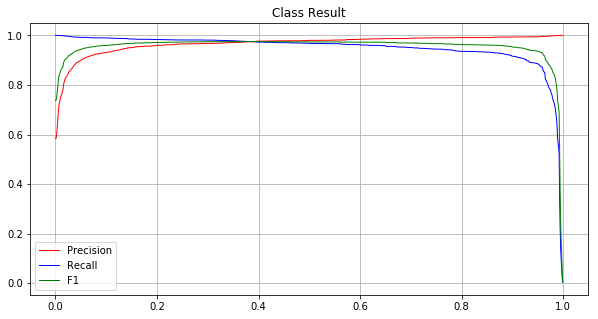

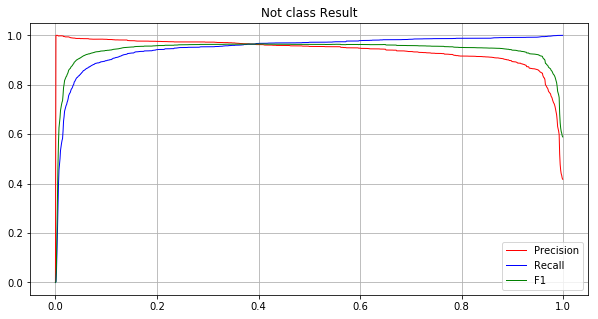

In [38]:
plot_results(train_docs, min_threshold=0, max_threshold=1, step=0.001, trace=1)

In [ ]:
TEST_DATA_FILE  = 'kaggle/kaggle_test_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = load_csv(TEST_DATA_FILE, calc_features)

In [ ]:
prediction = classifier.predict_all(test_docs)

11:12:29 INFO:Complete items 00000
11:12:29 INFO:Complete items 00000
11:12:29 INFO:Complete items 00000
11:12:29 INFO:Complete items 00000
11:13:01 INFO:Complete items 01000
11:13:01 INFO:Complete items 01000
11:13:01 INFO:Complete items 01000
11:13:01 INFO:Complete items 01000
11:13:29 INFO:Complete items 02000
11:13:29 INFO:Complete items 02000
11:13:29 INFO:Complete items 02000
11:13:29 INFO:Complete items 02000


In [ ]:
fout = open('my_submission.csv' , 'wb')
threshold = 0.5
try:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in prediction:
        p = 1 if item[3] > threshold else 0
        writer.writerow([item[0], p])
finally:
    fout.close()